In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# ============ РАСПАКОВКА АРХИВА ============
zip_path = "dataset.zip"   # путь до архива
extract_dir = "dataset"    # папка, куда распакуем

if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

# Ожидается структура:
# dataset/train/normal, dataset/train/Nenormal
# dataset/val/normal, dataset/val/Nenormal
# dataset/test/normal, dataset/test/Nenormal

In [3]:
# ============ ПАРАМЕТРЫ ============
batch_size = 32
num_classes = 2
epochs = 38
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============ ПРЕОБРАЗОВАНИЯ ============
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # ч/б
    transforms.Resize((28, 28)),                 # под DNDF
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
# ============ ДАТАСЕТЫ ============
train_dataset = ImageFolder(os.path.join(extract_dir, "train"), transform=transform)
val_dataset   = ImageFolder(os.path.join(extract_dir, "valid"), transform=transform)
test_dataset  = ImageFolder(os.path.join(extract_dir, "test"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(train_dataset.classes)

['Nenormal', 'normal']


In [5]:
# ============ DNDF МОДЕЛЬ ============
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Linear(32*5*5, 64)  # для 28x28 → 32*5*5

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [6]:
class DecisionNode(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.fc = nn.Linear(in_features, 1)

    def forward(self, x):
        return torch.sigmoid(self.fc(x))

In [7]:
class Leaf(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.probs = nn.Parameter(torch.ones(n_classes) / n_classes)

    def forward(self, batch_size):
        return self.probs.unsqueeze(0).repeat(batch_size, 1)

In [8]:
class DNDFTree(nn.Module):
    def __init__(self, in_features, n_classes=2):
        super().__init__()
        self.node1 = DecisionNode(in_features)
        self.node2 = DecisionNode(in_features)
        self.leaf1 = Leaf(n_classes)
        self.leaf2 = Leaf(n_classes)
        self.leaf3 = Leaf(n_classes)
        self.leaf4 = Leaf(n_classes)

    def forward(self, x):
        batch_size = x.size(0)
        p1 = self.node1(x)
        p2 = self.node2(x)

        path1 = (1 - p1) * (1 - p2)
        path2 = (1 - p1) * p2
        path3 = p1 * (1 - p2)
        path4 = p1 * p2

        out = (
            path1 * self.leaf1(batch_size) +
            path2 * self.leaf2(batch_size) +
            path3 * self.leaf3(batch_size) +
            path4 * self.leaf4(batch_size)
        )
        return out

In [9]:
class DNDF(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        self.feature_extractor = FeatureExtractor()
        self.tree = DNDFTree(64, n_classes)

    def forward(self, x):
        feats = self.feature_extractor(x)
        return self.tree(feats)

In [10]:
# ============ ОБУЧЕНИЕ ============
model = DNDF(num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses, test_losses = [], [], []
train_accs, val_accs, test_accs = [], [], []

for epoch in range(epochs):
    # ---- train ----
    model.train()
    correct, total, train_loss = 0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        correct += (preds.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_loss /= total
    train_acc = correct / total

    # ---- validation ----
    model.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            loss = criterion(preds, labels)
            val_loss += loss.item() * imgs.size(0)
            correct += (preds.argmax(1) == labels).sum().item()
            total += labels.size(0)

    val_loss /= total
    val_acc = correct / total

    # ---- test ----
    correct, total, test_loss = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            loss = criterion(preds, labels)
            test_loss += loss.item() * imgs.size(0)
            correct += (preds.argmax(1) == labels).sum().item()
            total += labels.size(0)

    test_loss /= total
    test_acc = correct / total

    # сохраняем всё
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train loss {train_loss:.4f}, acc {train_acc:.4f} | "
          f"Val loss {val_loss:.4f}, acc {val_acc:.4f} | "
          f"Test loss {test_loss:.4f}, acc {test_acc:.4f}")

Epoch 1/38 | Train loss 0.6203, acc 0.7648 | Val loss 0.4589, acc 0.9658 | Test loss 0.7020, acc 0.5499
Epoch 2/38 | Train loss 0.5392, acc 0.7896 | Val loss 0.3550, acc 0.9658 | Test loss 0.7296, acc 0.5569
Epoch 3/38 | Train loss 0.5113, acc 0.7938 | Val loss 0.3065, acc 0.9668 | Test loss 0.7514, acc 0.5559
Epoch 4/38 | Train loss 0.4969, acc 0.7998 | Val loss 0.2763, acc 0.9688 | Test loss 0.7706, acc 0.5569
Epoch 5/38 | Train loss 0.4019, acc 0.8606 | Val loss 0.2758, acc 0.9276 | Test loss 0.6263, acc 0.6746
Epoch 6/38 | Train loss 0.3509, acc 0.8842 | Val loss 0.1970, acc 0.9618 | Test loss 0.6245, acc 0.7021
Epoch 7/38 | Train loss 0.3261, acc 0.8902 | Val loss 0.2875, acc 0.8925 | Test loss 0.6112, acc 0.7264
Epoch 8/38 | Train loss 0.3082, acc 0.8954 | Val loss 0.2148, acc 0.9357 | Test loss 0.6260, acc 0.7323
Epoch 9/38 | Train loss 0.2845, acc 0.9051 | Val loss 0.1611, acc 0.9658 | Test loss 0.7686, acc 0.6762
Epoch 10/38 | Train loss 0.2703, acc 0.9081 | Val loss 0.1345, a

In [11]:
# ============ СОХРАНЕНИЕ ============
torch.save(model.state_dict(), "dndf_weights.pth")
print("Модель сохранена в dndf_weights.pth")

Модель сохранена в dndf_weights.pth


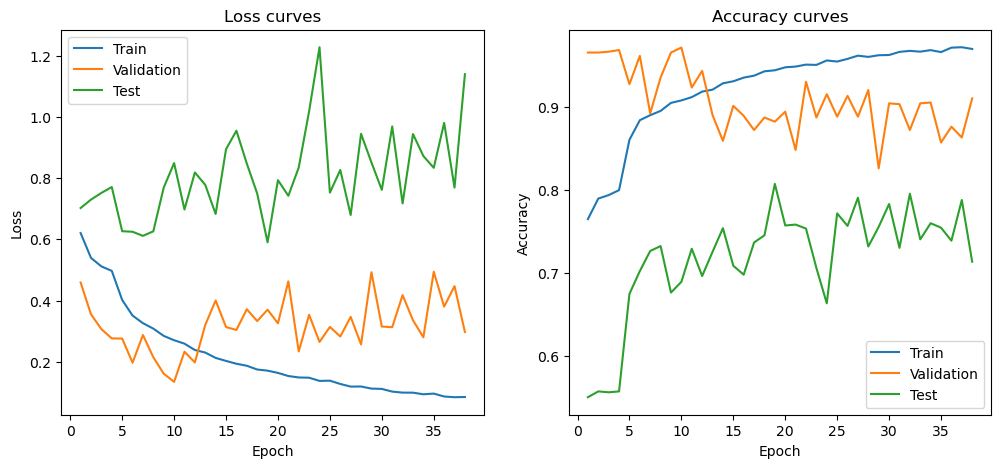

In [12]:
epochs_range = range(1, epochs+1)

plt.figure(figsize=(12,5))

# --- Loss ---
plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, label="Train")
plt.plot(epochs_range, val_losses, label="Validation")
plt.plot(epochs_range, test_losses, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss curves")
plt.legend()

# --- Accuracy ---
plt.subplot(1,2,2)
plt.plot(epochs_range, train_accs, label="Train")
plt.plot(epochs_range, val_accs, label="Validation")
plt.plot(epochs_range, test_accs, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy curves")
plt.legend()

plt.show()

In [13]:
import cv2
# загрузка модели
model = DNDF(num_classes).to(device)
model.load_state_dict(torch.load("dndf_weights.pth",map_location=device))
model.eval()

class_names = ["Nenormal", "normal"]

zip_path_run = "postDICOM.zip"   # путь до архива
extract_dir_run = "postDICOM"    # папка, куда распакуем

if not os.path.exists(extract_dir_run):
    with zipfile.ZipFile(zip_path_run, 'r') as zip_ref:
        zip_ref.extractall(extract_dir_run)

for root, _, files in os.walk(extract_dir_run):
    for filename in files:
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp")):
            path = os.path.join(root, filename)

            # загрузка изображения в grayscale
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (28,28))

            # преобразование в тензор
            tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 255.0
            tensor = (tensor - 0.5) / 0.5  # нормализация
            tensor = tensor.to(device)

            # предсказание
            with torch.no_grad():
                out = model(tensor)                       # сырые логиты
                probs = F.softmax(out, dim=1)          # вероятности
                cls = probs.argmax(1).item()           # индекс класса
                confidence = probs[0, cls].item() * 100

            print(f"{filename} -> {class_names[cls]} ({confidence:.2f}%)")

C:\Users\denvd\AppData\Local\Temp\ipykernel_3932\2273548721.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("dndf_weights.pth",map_locat

10000E6B_anon.png -> normal (99.09%)
10000E6C_anon.png -> normal (99.09%)
10000E6D_anon.png -> normal (99.09%)
10000E6E_anon.png -> normal (99.09%)
10000E6F_anon.png -> normal (99.09%)
10000E70_anon.png -> normal (99.09%)
10000E71_anon.png -> normal (99.09%)
10000E72_anon.png -> normal (99.09%)
10000E73_anon.png -> normal (99.09%)
10000E74_anon.png -> normal (99.09%)
10000E75_anon.png -> normal (99.09%)
10000E76_anon.png -> normal (99.09%)
10000E77_anon.png -> normal (99.09%)
10000E78_anon.png -> normal (99.09%)
10000E79_anon.png -> normal (99.09%)
10000E7A_anon.png -> normal (99.09%)
10000E7B_anon.png -> normal (99.09%)
10000E7C_anon.png -> normal (99.09%)
10000E7D_anon.png -> normal (99.09%)
10000E7E_anon.png -> normal (99.09%)
10000E7F_anon.png -> normal (99.09%)
10000E80_anon.png -> normal (99.09%)
10000E81_anon.png -> normal (99.09%)
10000E82_anon.png -> normal (99.09%)
10000E83_anon.png -> normal (99.09%)
10000E84_anon.png -> normal (99.09%)
10000E85_anon.png -> normal (99.09%)
1